## Ryans Work to decode barcodes

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from wand.image import Image
from wand.color import Color

In [2]:
def slidingNormalize(vs, wl):
    window = np.arange(0,wl)
    l = np.min(vs[window])
    h = np.max(vs[window])
    while l == h and wl < int(len(vs)):
        wl = wl + 2
        window = np.arange(0,wl)
        l = np.min(vs[window])
        h = np.max(vs[window])
    if l == h:
        for v in vs:
            yield v
    else:
        print("wl = ", wl)
        half = int(wl/2)
        for i in range(0,half):
            yield (vs[i] - l) / (h - l)
        for i in range(0,len(vs)-wl):
            window = window + 1
            l = np.min(vs[window])
            h = np.max(vs[window])
            yield (vs[i+half] - l) / (h - l)
        for i in range(0,half):
            yield (vs[i+len(vs)-half] - l) / (h - l)

def cropTo(img, xl,xh, yl,yh):
    return img[yl:yh, xl:xh]

def extractLine(img, y, adaptiveNormalize):
    w = img.shape[1]
    h = img.shape[0]
    xs = np.arange(w)
    if not adaptiveNormalize:
        ys = img[y,xs, 1]
        ys = ys - np.min(ys)
        ys = ys / np.max(ys)
    else:
        wl = int(w/10)
        print(wl)
        ys = img[y,xs, 1]
        ys = np.array(list(slidingNormalize(ys, wl)))
    return xs,ys

In [3]:
def crossings(t, ys):
    x = 0
    y0 = ys[0]
    h = y0 > t
    for y in ys:
        b = y > t
        if not (b == h): # transition
            # 1 --o
            #      \xi
            # t     \
            #        \
            # 0       o-----
            #     x   x+1
            xi = (t - y0) / (y - y0)
            h = b
            yield x - 1 + xi
        x = x + 1
        y0 = y
    #yield x

def widths(cs):
    first = True
    for x in cs:
        if first:
            first = False
        else:
            yield x - x0
        x0 = x
        
def barsToImg(bars):
    quiet = [1,1,1,1,1,1,1,1,1]
    bs = quiet + list(bars) + quiet
    return np.transpose(np.reshape(np.array(np.repeat(bs,20)), (len(bs), 20)))

In [4]:
def widthsToBlocks(ws):
    cal = np.array([ws[0],ws[1],ws[2],ws[-1],ws[-2],ws[-3]])
    l = np.average(cal)
    print(l)
    total = sum(np.round(ws/l).astype(int))
    while not (total == 95) and sum(np.round(cal/l).astype(int)) == 6:
        if total < 95:
            l = l - 0.01
        else:
            l = l + 0.01
        total = sum(np.round(ws/l).astype(int))
    return zip(np.round(ws/l).astype(int), np.tile([0,1],int(len(ws)/2)+1))
    #l = np.average([ws[0],ws[1],ws[2],ws[-1],ws[-2],ws[-3]])
    #return zip(np.round(ws/l).astype(int), np.tile([0,1],int(len(ws)/2)+1))

def blocksToBars(bs):
    for (n,c) in bs:
        for i in range(0,n):
            yield c
            
def splitBy(ss, vs):
    return zip(vs, blocksToBars(zip(ss, range(0,len(ss)))))

def readEAN(ws):
    bars = blocksToBars(widthsToBlocks(ws))
    ss = splitBy([3, 6*7, 5, 6*7, 3], bars)
    return list(ss)


digitsL = { "[1 1 1 0 0 1 0]": 0,
            "[1 1 0 0 1 1 0]": 1,
            "[1 1 0 1 1 0 0]": 2,
            "[1 0 0 0 0 1 0]": 3,
            "[1 0 1 1 1 0 0]": 4,
            "[1 0 0 1 1 1 0]": 5,
            "[1 0 1 0 0 0 0]": 6,
            "[1 0 0 0 1 0 0]": 7,
            "[1 0 0 1 0 0 0]": 8,
            "[1 1 1 0 1 0 0]": 9
          }
digitsG = { "[1 0 1 1 0 0 0]": 0, 
            "[1 0 0 1 1 0 0]": 1, 
            "[1 1 0 0 1 0 0]": 2, 
            "[1 0 1 1 1 1 0]": 3, 
            "[1 1 0 0 0 1 0]": 4, 
            "[1 0 0 0 1 1 0]": 5, 
            "[1 1 1 1 0 1 0]": 6, 
            "[1 1 0 1 1 1 0]": 7, 
            "[1 1 0 1 0 0 0]": 8, 
            "[1 1 0 1 0 0 0]": 9
          }

digits0 = { "LLLLLL": 0,
            "LLGLGG": 1,
            "LLGGLG": 2,
            "LLGGGL": 3,
            "LGLLGG": 4,
            "LGGLLG": 5,
            "LGGGLL": 6,
            "LGLGLG": 7,
            "LGLGGL": 8,
            "LGGLGL": 9    
          }

def digitEAN(bars):
    s = str(bars)
    if s in digitsL:
        return ('L', digitsL[s])
    elif s in digitsG:
        return ('G', digitsG[s])
    return ('X', "X -- " + s)

def checksumEAN13(n):
    if not all(isinstance(x, int) for x in n) or not (len(n) == 13):
        return False
    d = 10 - int(np.dot(n[0:12], np.tile([1,3], 6))) % 10
    return d == n[12]

def widthsToEAN13(ws):
    zones = readEAN(ws)
    # print(zones)
    ls = np.reshape(np.array(list(map(lambda v: v[0], filter(lambda v: v[1] == 1, zones)))), (6,7))
    rs = np.reshape(np.array(list(map(lambda v: 1 - v[0], filter(lambda v: v[1] == 3, zones)))), (6,7))
    #print(ls)
    #print(rs)
    s = ""
    n = []
    for i in range(0,6):
        (c,d) = digitEAN(ls[i])
        s = s + c
        n = n + [d]
        #print(c, d)
    for i in range(0,6):
        (c,d) = digitEAN(rs[i])
        n = n + [d]
        #print(c, d)
    if s in digits0:
        n = [digits0[s]] + n
        #print(n)
    #else:
        #print(s, n)
    return (checksumEAN13(n), n)

def decodeEAN13(img, y, t, adaptiveNormalize):
    xs,ys = extractLine(img, y, adaptiveNormalize)
    cs = np.array(list(crossings(t, ys)))
    ws = np.array(list(widths(cs)))
    plt.figure(figsize=(15,1))
    plt.plot(xs,ys,'-')
    plt.plot(cs, np.full(len(cs), t), '.')
    plt.show()
    
    (valid, code) = widthsToEAN13(ws)
    if valid:
        plt.imshow(img)
        print(code)
        return (valid, code)
    # helpful debugging information
    print(list(ws))
    l = np.average([ws[0],ws[1],ws[2],ws[-1],ws[-2],ws[-3]])
    print(list(np.round(ws/l).astype(int)))
    plt.imshow(barsToImg(blocksToBars(widthsToBlocks(ws))))
    return (valid, code)

In [6]:
# Some code to remove transparency from examples from wikipeida
#with Image(filename='200px-Example_barcode.svg.png') as wimg:
#with Image(filename='500px-Wikipedia_barcode_128.svg.png') as wimg:
with Image(filename='500px-EAN-13-5901234123457.svg.png') as wimg:
#with Image(filename='500px-UPC-A-036000291452.svg.png') as wimg:
    with Color('#fff') as white:
        with Image(width=wimg.width, height=wimg.height, background=white) as back:
            back.save(filename='back.png')
            back.composite(wimg,0,0)
            back.save(filename='test5.png')

50
wl =  68


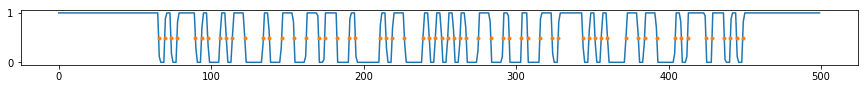

4.019394839765371
[5, 9, 0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 7]


(True, [5, 9, 0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 7])

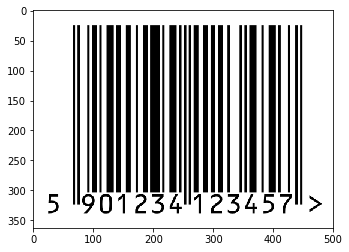

In [7]:
decodeEAN13(cv2.imread('test5.png'), 40, 0.5, True)

190
wl =  190


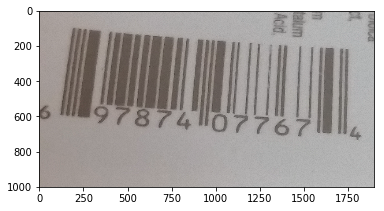

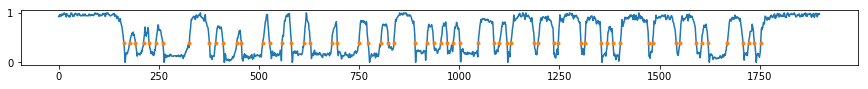

15.614509802160242
[0, 6, 9, 7, 8, 7, 4, 0, 7, 7, 6, 7, 4]


(True, [0, 6, 9, 7, 8, 7, 4, 0, 7, 7, 6, 7, 4])

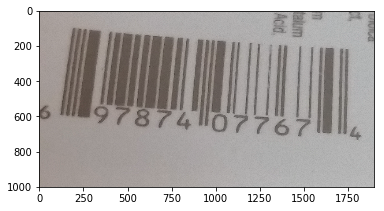

In [8]:
img = cropTo(cv2.imread('Jon/20190113_154445.jpg'), 600,2500, 2000,3000)
plt.imshow(img)
decodeEAN13(img, 300, 0.4, True)

## My work to automatically find barcodes in images and croping the image to just show the barcode

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from wand.image import Image
from wand.color import Color
import math

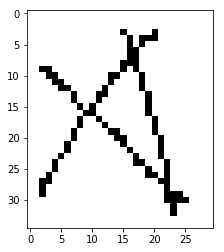

In [29]:
img = cv2.imread('A.png')
plt.imshow(img)

In [35]:
w = img.shape[0]
h = img.shape[1]
phis = np.zeros((int(round(math.sqrt(w*w + h*h))),180))

35
30


In [33]:
for x in range(0,w):
    for y in range(0,h):
        r = math.sqrt(x*x + y*y)
        if img[y,x,1] < 128:
            for phi in range(0,180):
                l = int(r * math.sin(phi * math.pi/180))
                phis[l,phi] += 1
phis = phis/np.max(phis)*255

IndexError: index 30 is out of bounds for axis 1 with size 30

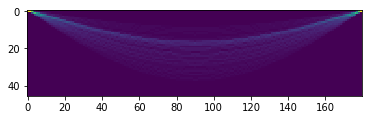

In [34]:
plt.imshow(phis)

Look into the Hough Line transform for detecting lines